# 1. Setup Mario

In [1]:
import gym
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
import numpy as np
import time

from gym.wrappers import GrayScaleObservation
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from matplotlib import pyplot as plt

import os 
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback

import torch
torch.cuda.is_available()

True

# 2. Preprocess Environment

In [2]:
class SkipFrame(gym.Wrapper):
    '''
        Custom wrapper that inherits from gy.Wrapper and implements the step() function.
        Use it to return only every skip nth frame
    '''
    def __init__(self, env, skip):
        super().__init__(env)
        self._skip = skip
        
    def step(self, action):
        total_reward = 0.0
        done = False
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info

In [22]:
env = gym.make('SuperMarioBrosRandomStages-v1', stages=['1-1'])
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = GrayScaleObservation(env, keep_dim=True)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, 4, channels_order='last')

env = SkipFrame(env, 4)

In [23]:
state = env.reset()

In [24]:
state, reward, done, info = env.step([5])
state, reward, done, info = env.step([5])
state, reward, done, info = env.step([5])

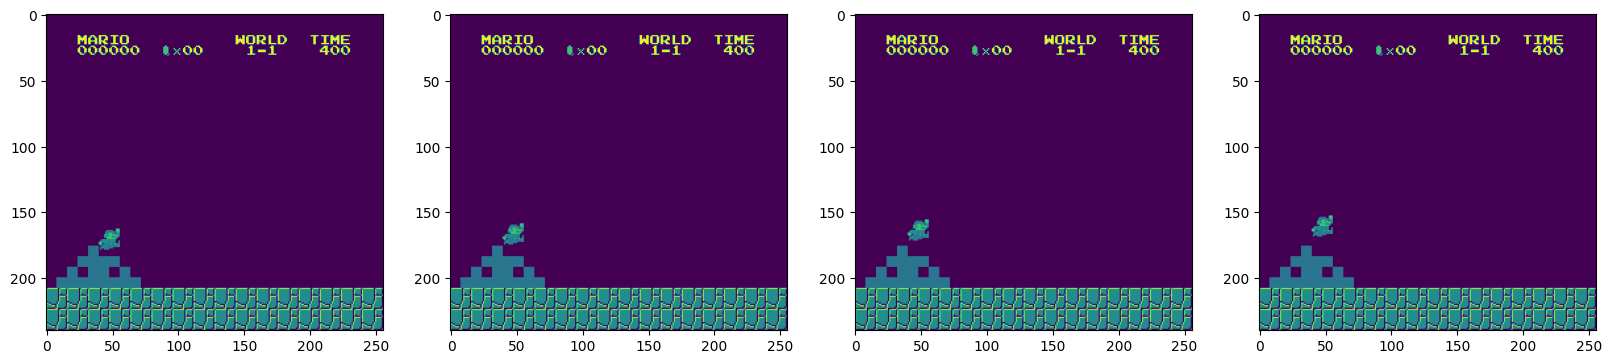

In [25]:
plt.figure(figsize=(20,16))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

# 3. Train the RL Model

In [53]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

callback = TrainAndLoggingCallback(check_freq=100000, save_path=CHECKPOINT_DIR)

In [8]:
continue_train = False

if continue_train:
    model = PPO.load('./train/SuperMarioBros-1-1-v1-model-7.83M') # , learning_rate= 0.000001)
    model.set_env(env)
else:
    model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate= 0.000001, # 0.000001, 
            n_steps=512, device="cuda")

Wrapping the env in a VecTransposeImage.


In [10]:
model.learn(total_timesteps=3000000, callback=callback)

Logging to ./logs/PPO_18
----------------------------
| time/              |     |
|    fps             | 104 |
|    iterations      | 1   |
|    time_elapsed    | 4   |
|    total_timesteps | 512 |
----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 84          |
|    iterations           | 2           |
|    time_elapsed         | 12          |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.002256419 |
|    clip_fraction        | 0.0105      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.571      |
|    explained_variance   | 0.755       |
|    learning_rate        | 1e-06       |
|    loss                 | 43          |
|    n_updates            | 152680      |
|    policy_gradient_loss | -0.00383    |
|    value_loss           | 143         |
-----------------------------------------
----------------

In [11]:
model.save('./train/SuperMarioBros-1-1-v1-model-10M')

# 4. Save actions best run

In [29]:
model = PPO.load('./train/SuperMarioBros-1-1-v1-model-10M') # 1.000.000 + 230.000 + 4.000.000 + 600.000 + 2.000.000 + 2.170.000

In [43]:
model = PPO.load('./train/best_model_2150000')

In [44]:
env = gym.make('SuperMarioBrosRandomStages-v1', stages=['1-1'])
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = GrayScaleObservation(env, keep_dim=True)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, 4, channels_order='last')


In [ ]:
# model.set_random_seed(seed=42)

# env.seed(42)
# env.action_space.seed(42)

# torch.manual_seed(42)
# torch.random.manual_seed(42)

# np.random.seed(42)

In [45]:
state = env.reset()
rewards = []
total_reward = 0

best_run = (0, [])
action_list = []

while True:

    action, _ = model.predict(state)
    action_list.append(action)
    state, reward, done, info = env.step(action)

    if done:

        if total_reward > best_run[0]: 
            best_run = (total_reward, action_list.copy())

        action_list = []

        rewards.append(total_reward)
        total_reward = 0
        state = env.reset()
    else:
        total_reward += reward

    if len(rewards) > 100:
        break

rewards = np.array(rewards)

Min: 251.0  Mean: 1303.0  Max: 1940.0


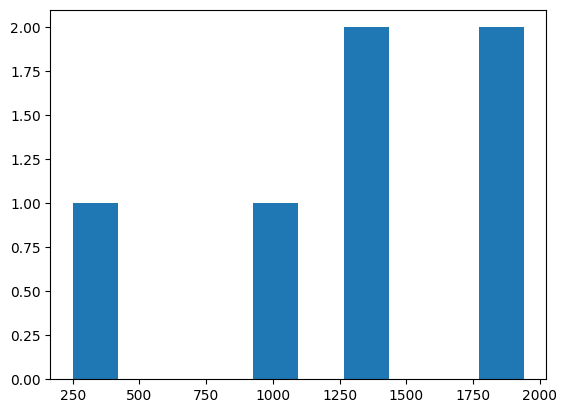

In [46]:
print('Min:',rewards.min(),' Mean:',rewards.mean(),' Max:',rewards.max())
plt.hist(rewards)
plt.show()

# 5. Simulate best run

In [41]:
env = gym.make('SuperMarioBrosRandomStages-v0', stages=['1-1'])
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = GrayScaleObservation(env, keep_dim=True)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, 4, channels_order='last')

In [42]:
for _ in range(1):
    state = env.reset()

    for action in best_run[1]:

        state, reward, done, info = env.step(action)

        if done:
            state = env.reset()
        time.sleep(0.01)
        env.render()
env.close()

# 6. Test in unknown level (2-1)

In [ ]:
env = gym.make('SuperMarioBrosRandomStages-v1', stages=['2-1'])
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = GrayScaleObservation(env, keep_dim=True)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, 4, channels_order='last')

In [ ]:
for _ in range(20):

    state = env.reset()

    while True:

        action, _ = model.predict(state)
        state, reward, done, info = env.step(action)

        if done:
            state = env.reset()

        time.sleep(0.001)
        
        env.render()
env.close()